In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import TypedDict, Literal, List, Union
import os
import json
import re


from langchain_core.tools import tool
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_core.messages import HumanMessage, SystemMessage,ToolMessage
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate

from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams
from dotenv import load_dotenv
from tqdm import tqdm
from langchain_core.documents import Document
import time

from collections import defaultdict
from datetime import datetime


/Users/debasmitroy/Desktop/rakuten-codes/final/ai-backend-0/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_stored_result(path:str, type:Literal["json","csv"]):
    # Check if the path is valid
    if not os.path.exists(path):
        return None 
    if type == "json":
        with open(path, 'r') as f:
            data = json.load(f)
        return data
    elif type == "csv":
        with open(path, 'r') as f:
            data = json.load(f)
        return data
    else:
        return None 
    
def save_result(result, path:str, type:Literal["json","csv"]):
    if type == "json":
        with open(path, 'w') as f:
            json.dump(result, f, indent=4)
    elif type == "csv":
        #  check if the result is a dataframe
        if isinstance(result, pd.DataFrame):
            result.to_csv(path, index=False)
        else:
            print("The result is not a dataframe")
            raise ValueError("The result is not a dataframe")
    else:
        print("Invalid type")
        raise ValueError("Invalid type")

In [3]:
class LangchainJSONEngine:
    def __init__(self, sampleBaseModel: BaseModel, systemPromptText: str=None, humanPromptText: str=None):
        self.llm = llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)
        self.structured_llm = llm.with_structured_output(sampleBaseModel)
        
        if systemPromptText is None:
            self.systemPromptText = """
            You are an AI assistant. You are helping a user with a task. The user is asking you questions and you are answering them.
            """
        else:
            self.systemPromptText = systemPromptText

        if humanPromptText is None:
            self.HumanPromptText = """
            Human: {query}
            """
        else:
            self.humanPromptText = humanPromptText

        self.prompt = ChatPromptTemplate.from_messages(
            [("system", self.systemPromptText), ("human", "Query:\n\n {query}")])
        
        self.micro_agent = self.prompt | self.structured_llm

    def run(self, query: str):
        result = self.micro_agent.invoke({
            "query": query
        }) 
        return result

## Runing the fake score

In [4]:
# fake_reviews = get_stored_result("./data/user-reviews-fake.json", "json")
# all_cats = get_stored_result("./stored-result/all-cats.json", "json")

### Catefory wise parameters

In [5]:
class RevieParemeters(BaseModel):
    review_params : List[str] = Field("All different parameters that can be used to describe a review to analyze the goodness of the product")


def generate_category_wise_params(product_cat):

    systemPromptText = """You are an AI assistant. 
    You are an AI tool that helps users analyze the goodness of a product based on the reviews.
    You are given with a product category. 
    You need to generate the detailed parameters that can be used to describe a review to analyze the goodness of the product.
    Example: for a technology product, the parameters can be [performance of a product, durabilty of product, battery life of product(camera, mobile etc.)].
    """

    query = f"""
    Product category: {product_cat}
    """

    engine = LangchainJSONEngine(RevieParemeters, systemPromptText=systemPromptText)
    result = engine.run(query).dict()

    
    return result

In [6]:
def generate_category_wise_params_all_cats(all_cats,store_path='./stored-result/cat-wise-params.json',use_stored=True):

    if use_stored and os.path.exists(store_path):
        print("Using stored result")
        return get_stored_result(store_path, "json")
    
    result = {}
    for _,cat in all_cats[0].items():
        params = generate_category_wise_params(cat)
        result[cat] = params["review_params"]

    save_result(result, store_path, "json")
    return result

In [7]:
# cat_wise_params = generate_category_wise_params_all_cats(all_cats)

In [8]:
# cat_wise_params

### Catgeory wise Pydantic schemas

In [9]:
class ToolsAndHardwareScores(BaseModel):
    Durability: int = Field("Durability of the product. 0 means negative, 1 means neutral, 2 means positive")
    EaseOfUse: int = Field("Ease of use of the product. 0 means negative, 1 means neutral, 2 means positive")
    Versatility: int = Field("Versatility of the product. 0 means negative, 1 means neutral, 2 means positive")
    QualityofMaterials: int = Field("Quality of materials used in the product. 0 means negative, 1 means neutral, 2 means positive")
    Portability: int = Field("Portability of the product. 0 means negative, 1 means neutral, 2 means positive")
    ValueforMoney: int = Field("Value for money of the product. 0 means negative, 1 means neutral, 2 means positive")

In [10]:
def analyze_review(review_text_date,pydanaic_model):
    systemPromptText = """You are an AI assistant. 
    You are an AI tool that helps users analyze the goodness of a product based on the reviews.
    You are given with a review text.
    You need to analyze the review and provide scores for different parameters.
    Example: for a review text "The product is good and durable", the scores can be [Durability: 2, Ease of use: 2, Versatility: 1, Quality of materials: 2, Portability: 1, Value for money: 2].
    """

    query = f"""
    Review text: {review_text_date[0]}
    """

    engine = LangchainJSONEngine(pydanaic_model, systemPromptText=systemPromptText)
    result = engine.run(query).dict()
    datetime = review_text_date[1]
    final_result = [
       result,datetime
    ]
    return final_result


In [11]:
def analyze_product_id(product_id, firs_level_cat, reviews_map, store_path='./stored-result/product-reviews-parmas.json', use_stored=True):

    cat_to_pydatnic_model = {
        "tools_hardware": ToolsAndHardwareScores
    }

    pydanaic_model = cat_to_pydatnic_model[firs_level_cat]

    if use_stored and os.path.exists(store_path):
        print("Using stored result")
        stored_data = get_stored_result(store_path, "json")
        if product_id in stored_data:
            return stored_data[product_id]
    reviews = reviews_map[product_id]
    results = []
    for _,review in tqdm(reviews.items()):
        result = analyze_review(review,pydanaic_model)
        results.append(result)

    final_result = {
             product_id:results
        }
    if os.path.exists(store_path):
        stored_result = get_stored_result(store_path, "json")
        stored_result.update(final_result)
        save_result(stored_result, store_path, "json")
    else:
        save_result(final_result, store_path, "json")
    return final_result

In [12]:
# final_result = analyze_product_id("zeb-u725-600VA", firs_level_cat = "tools_hardware",reviews_map=fake_reviews, use_stored=True, store_path='./stored-result/product-reviews-parmas.json')

In [13]:
def calculate_monthly_averages(data):
    # Initialize dictionaries to store sums and counts for each month
    monthly_sums = defaultdict(lambda: defaultdict(float))
    monthly_counts = defaultdict(int)
    
    for item in data:
        parameters, date_str = item
        date = datetime.strptime(date_str, "%Y-%m-%d %H:%M:%S")
        month_key = date.strftime("%Y-%m")
        
        # Update sums and counts
        for key, value in parameters.items():
            monthly_sums[month_key][key] += value
        monthly_counts[month_key] += 1
    
    # Calculate averages
    monthly_averages = []
    for month, sums in monthly_sums.items():
        count = monthly_counts[month]
        averages = {f"Avg {key}": (value / count) for key, value in sums.items()}
        # All parameter avg
        averages["Aggregated Score"] = sum(averages.values()) / len(averages)
        averages["No interactions"] = count
        monthly_averages.append([averages, month])

    # last three months avg of aggregated score

    last_three_months_avg = sum([item[0]["Aggregated Score"] for item in monthly_averages[-3:]]) / 3   
    
    return monthly_averages,last_three_months_avg

In [14]:
# monthly_averages,last_three_months_avg = calculate_monthly_averages(final_result)

### Streamline The Flow

In [31]:
def calculate_review_details(product_id,first_level_cat, reviews_map_path, use_stored=True, store_path = './stored-result/product-reviews-parmas.json'):
    fake_reviews = get_stored_result(reviews_map_path, "json")
    final_result = analyze_product_id(product_id, firs_level_cat = first_level_cat,reviews_map=fake_reviews, use_stored=use_stored, store_path=store_path)
    monthly_averages,last_three_months_avg = calculate_monthly_averages(final_result)
    return monthly_averages,last_three_months_avg

In [32]:
monthly_averages,last_three_months_avg = calculate_review_details("0513ab340eced913dce82594bd118ff0", "tools_hardware", "./data/user-reviews-fake.json")

Using stored result


In [33]:
last_three_months_avg

0.7037037037037038

In [29]:
import matplotlib.pyplot as plt

def plot_monthly_averages(data):
    # Prepare lists to hold data for plotting
    months = []
    avg_durability = []
    avg_ease_of_use = []
    avg_versatility = []
    avg_quality_of_materials = []
    avg_portability = []
    avg_value_for_money = []
    no_interactions = []
    all_avg = []

    # Extract data from the input
    for entry in data:
        stats, month = entry
        months.append(month)
        avg_durability.append(stats.get('Avg Durability', 0))
        avg_ease_of_use.append(stats.get('Avg EaseOfUse', 0))
        avg_versatility.append(stats.get('Avg Versatility', 0))
        avg_quality_of_materials.append(stats.get('Avg QualityofMaterials', 0))
        avg_portability.append(stats.get('Avg Portability', 0))
        avg_value_for_money.append(stats.get('Avg ValueforMoney', 0))
        all_avg.append(stats.get('Aggregated Score', 0))
        # no_interactions.append(stats.get('No interactions', 0))


    # Create the plot
    plt.figure(figsize=(12, 8))

    plt.plot(months, avg_durability, marker='o', label='Avg Durability')
    plt.plot(months, avg_ease_of_use, marker='o', label='Avg EaseOfUse')
    plt.plot(months, avg_versatility, marker='o', label='Avg Versatility')
    plt.plot(months, avg_quality_of_materials, marker='o', label='Avg QualityofMaterials')
    plt.plot(months, avg_portability, marker='o', label='Avg Portability')
    plt.plot(months, avg_value_for_money, marker='o', label='Avg ValueforMoney')
    # More deep color
    plt.plot(months, all_avg, marker='o', linestyle='--', label='Aggregated Score', color='black', linewidth=4)
    # plt.plot(months, no_interactions, marker='o', linestyle='--', label='No interactions', color='black')

    # Add labels and title
    plt.xlabel('Month')
    plt.ylabel('Average Values')
    plt.title('Monthly Averages and Interaction Counts')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.tight_layout()
    plt.show()

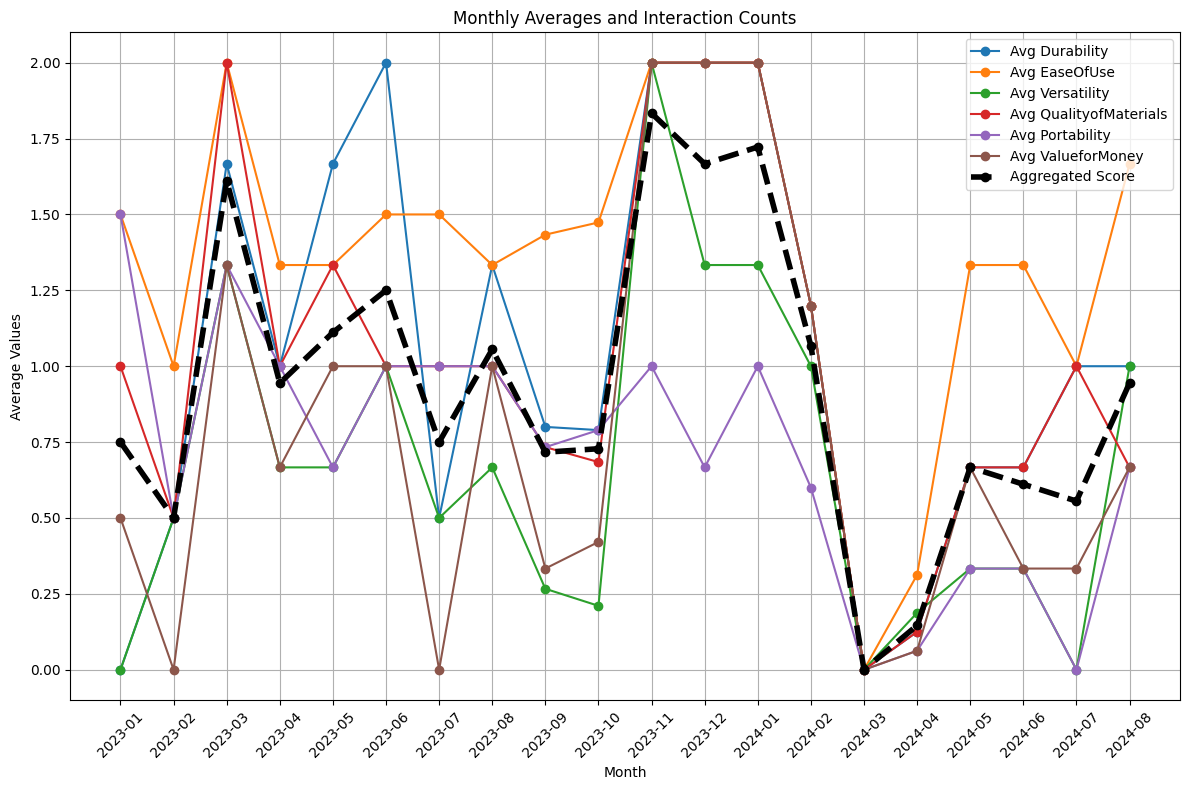

In [30]:
plot_monthly_averages(monthly_averages)